In [51]:
import sys, os, copy, re, pathlib
from natsort import natsorted
import pandas as pd
import seaborn as sns
from scipy.optimize import newton, minimize, fsolve
import numpy as np
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
%matplotlib inline

In [52]:
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

In [53]:
def approx_ratio_stats(a, b):
    # Making a lot of assumptions about normality
    # and no covariance estimate ratio stats:
    # https://chem.libretexts.org/Bookshelves/Analytical_Chemistry/Supplemental_Modules_(Analytical_Chemistry)/Quantifying_Nature/Significant_Digits/Propagation_of_Error
    # I think this is derived from the first term of a Taylor expansion of the real solution.
    a_mean, a_stdev = a
    b_mean, b_stdev = b
    ratio_mean = a_mean / b_mean
    ratio_stdev = ratio_mean * np.sqrt((a_stdev / a_mean)**2 + (b_stdev / b_mean)**2)
    return((ratio_mean, ratio_stdev))

In [54]:
# Convert row letter to integer,
# for indicating replicates:
letter2rep = {'A': 1, 'B': 2, 'C': 3, 'D': 4}

In [55]:
# Read sample annotations:
sample_anno = pd.read_excel('sample_annotations.xlsx')
sample_anno

,Cell_line,Folder,Plate,Time_first_mes,Timepoints,Drug,Col 1,Col 2,Col 3,Col 4,Col 5,Col 6
0,HT1080-WT_ATF4-rep,01-10-22_high,p1,17.0,False,Vehicle,Vehicle,Asn,SM,Asp,Pyr,aKB
1,HT1080-WT_ATF4-rep,01-10-22_high,p2,17.0,False,Rotenone,Vehicle,Asn,SM,Asp,Pyr,aKB
2,HT1080-WT_ATF4-rep,01-10-22_high,p3,17.0,False,Antimycin,Vehicle,Asn,SM,Asp,Pyr,aKB
3,HT1080-WT_ATF4-rep,01-10-22_high,p4,17.0,False,Oligomycin,Vehicle,Asn,SM,Asp,Pyr,aKB
4,HT1080-WT_ATF4-rep,01-10-22_high,p5,17.0,False,FCCP,Vehicle,Asn,SM,Asp,Pyr,aKB
5,HT1080-WT_ATF4-rep,01-10-22_high,p6,17.0,False,Mix,Vehicle,Rot,Atp,Atp+Rot,Atp+Asn,Atp+Asp
6,HT1080-WT_ATF4-rep,01-11-22_low,p1,17.0,False,Vehicle,Vehicle,Asn,SM,Asp,Pyr,aKB
7,HT1080-WT_ATF4-rep,01-11-22_low,p2,17.0,False,Rotenone,Vehicle,Asn,SM,Asp,Pyr,aKB
8,HT1080-WT_ATF4-rep,01-11-22_low,p3,17.0,False,Antimycin,Vehicle,Asn,SM,Asp,Pyr,aKB
9,HT1080-WT_ATF4-rep,01-11-22_low,p4,17.0,False,Oligomycin,Vehicle,Asn,SM,Asp,Pyr,aKB


# Process HT1080 data from 01-10-22 and 01-11-22

In [11]:
### Process HT1080 data from 01-10-22 and 01-11-22 ###
cell_line_folder = 'HT1080-WT_ATF4-rep'
date_list = ['01-10-22', '01-11-22']

# Read data into dataframe:
data = pd.DataFrame(columns=['Folder', 'Plate', 'Drug', 'Rescue', 'Replicate', 'RFP', 'RFP_norm'])
row_idx = 0
home_p = pathlib.Path('data/{}'.format(cell_line_folder))
for path in home_p.glob('*'):
    folder = str(path).split('/')[-1]
    # Require the date to be part of folder name:
    if sum(1 for d in date_list if d in folder) == 0:
        continue
    for fnam in natsorted(home_p.glob('{}/*.txt'.format(folder))):
        plate = str(fnam).split('/')[-1][:-4]
        tmp_df = pd.read_csv(fnam, skiprows=1, sep='\t')
        for colnam, val in zip(tmp_df.columns, tmp_df.loc[0].values):
            if colnam[0] in 'ABCD' and colnam[1] in '123456':
                pass
            else:
                continue

            rep = letter2rep[colnam[0]]
            col = 'Col {}'.format(colnam[1])
            mask = (sample_anno['Folder'] == folder) & (sample_anno['Plate'] == plate)
            drug = sample_anno.loc[mask, 'Drug'].values[0]
            rescue = sample_anno.loc[mask, col].values[0]
            data_list = [folder, plate, drug, rescue, rep, val, 0]
            data.loc[row_idx, :] = data_list
            row_idx += 1

In [12]:
# Normalize to vehicle/vehicle:
for folder in set(data['Folder'].values):
    for mix in [True, False]:
        if mix:
            mask_folder_mix = (data['Folder'] == folder) & (data['Drug'] == 'Mix')
            mask_denom = (data['Folder'] == folder) & (data['Drug'] == 'Mix') & (data['Rescue'] == 'Vehicle')
        else:
            mask_folder_mix = (data['Folder'] == folder) & (data['Drug'] != 'Mix')
            mask_denom = (data['Folder'] == folder) & (data['Drug'] == 'Vehicle') & (data['Rescue'] == 'Vehicle')
            
        RFP_denom = data.loc[mask_denom, 'RFP'].values.mean()
        data.loc[mask_folder_mix, 'RFP_norm'] = data.loc[mask_folder_mix, 'RFP'] / RFP_denom

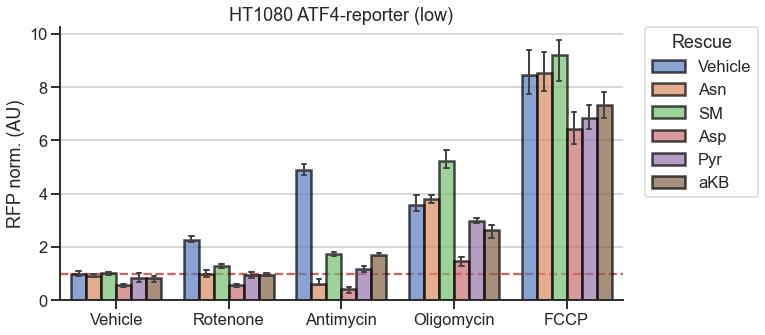

In [13]:
### Plot mito inhibitors for HT1080 ATF4-rep (low) ###

fig, ax1 = plt.subplots(1, 1, figsize=(11, 5))
folder = '01-11-22_low'

mask = (data['Folder'] == folder) & (data['Drug'] != 'Mix')
g1 = sns.barplot(ax=ax1, data=data[mask], x='Drug', y='RFP_norm', hue='Rescue', ci=99, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
ax1.axhline(y=1, color='r', linestyle='--', zorder=0)

g1.set_ylabel('RFP norm. (AU)')
g1.set_xlabel('')
g1.set_title('HT1080 ATF4-reporter (low)')
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Rescue')
#g1.set(yscale="log")


sns.despine()
fig.tight_layout()
fig.savefig('plots/{}-mito-inhib.pdf'.format(folder), bbox_inches='tight')

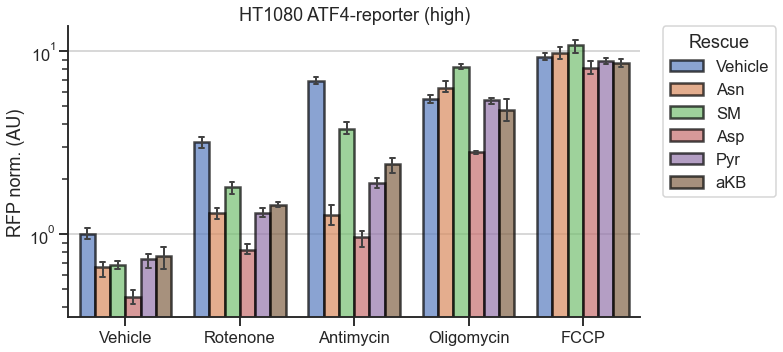

In [117]:
### Plot mito inhibitors for HT1080 ATF4-rep (high) ###

fig, ax1 = plt.subplots(1, 1, figsize=(11, 5))
folder = '01-10-22_high'

mask = (data['Folder'] == folder) & (data['Drug'] != 'Mix')
g1 = sns.barplot(ax=ax1, data=data[mask], x='Drug', y='RFP_norm', hue='Rescue', ci=99, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)
#ax1.axhline(y=1, color='r', linestyle='--', zorder=0)

g1.set_ylabel('RFP norm. (AU)')
g1.set_xlabel('')
g1.set_title('HT1080 ATF4-reporter (high)')
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Rescue')
g1.set(yscale="log")


sns.despine()
fig.tight_layout()
fig.savefig('plots/{}-mito-inhib_log.pdf'.format(folder), bbox_inches='tight')

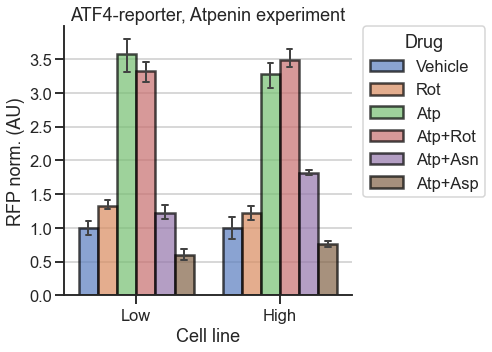

In [135]:
### Plot Atpenin data ###

fig, ax1 = plt.subplots(1, 1, figsize=(7, 5))

mask = (data['Drug'] == 'Mix')
g1 = sns.barplot(ax=ax1, data=data[mask], x='Folder', y='RFP_norm', hue='Rescue', ci=99, capsize=.04, errwidth=2, edgecolor='black', linewidth=2.5, alpha=0.7, zorder=1)

g1.set_xlabel('Cell line')
g1.set_ylabel('RFP norm. (AU)')
g1.set_title('ATF4-reporter, Atpenin experiment')
g1.grid(True, axis='y')
g1.set_xticklabels(['Low', 'High'])
g1.legend(bbox_to_anchor=(1.04,1), borderaxespad=0, title='Drug')

sns.despine()
fig.tight_layout()
fig.savefig('plots/01-1X-22_low_high_Atpenin.pdf', bbox_inches='tight')

In [166]:
### Process 143B data from 01-24-22 and 01-26-22 ###
cell_line_folder = '143B-WT_ATF4-rep'
date_list = ['01-24-22', '01-26-22']

# Read data into dataframe:
data = pd.DataFrame(columns=['Folder', 'Plate', 'Time', 'Drug', 'Rescue', 'Replicate', 'RFP', 'RFP_norm'])
row_idx = 0
home_p = pathlib.Path('data/{}'.format(cell_line_folder))
for path in home_p.glob('*'):
    folder = str(path).split('/')[-1]
    # Require the date to be part of folder name:
    if sum(1 for d in date_list if d in folder) == 0:
        continue
    for fnam in natsorted(home_p.glob('{}/*.txt'.format(folder))):
        plate = str(fnam).split('/')[-1][:-4]
        tmp_df = pd.read_csv(fnam, skiprows=1, sep='\t')
        
        for time_idx in range(len(tmp_df)):
            elapsed = tmp_df.loc[time_idx, 'Elapsed']
            for colnam, val in zip(tmp_df.columns, tmp_df.loc[time_idx].values):
                if colnam[0] in 'ABCD' and colnam[1] in '123456':
                    pass
                else:
                    continue

                rep = letter2rep[colnam[0]]
                col = 'Col {}'.format(colnam[1])
                mask = (sample_anno['Folder'] == folder) & (sample_anno['Plate'] == plate)
                time = elapsed + sample_anno.loc[mask, 'Time_first_mes'].values[0]
                drug = sample_anno.loc[mask, 'Drug'].values[0]
                rescue = sample_anno.loc[mask, col].values[0]
                data_list = [folder, plate, time, drug, rescue, rep, val, 0]
                data.loc[row_idx, :] = data_list
                row_idx += 1
data.RFP = data.RFP.astype(float)
data.Time = data.Time.astype(float)

In [167]:
# Normalize to vehicle/vehicle:
data['RFP_vec'] = 0
for folder in set(data['Folder'].values):
    for mix in [True, False]:
        if mix:
            mask_folder_mix = (data['Folder'] == folder) & (data['Drug'] == 'Mix')
            mask_denom = (data['Folder'] == folder) & (data['Drug'] == 'Mix') & (data['Rescue'] == 'Vehicle')
        else:
            mask_folder_mix = (data['Folder'] == folder) & (data['Drug'] != 'Mix')
            mask_denom = (data['Folder'] == folder) & (data['Drug'] == 'Vehicle') & (data['Rescue'] == 'Vehicle')
        # Extract Vehicle RFP:
        df_vec = data.loc[mask_denom, ['Time', 'RFP']].groupby('Time').mean()
        # Merge based on time:
        df_b = data.loc[mask_folder_mix, ]
        df_b_merged = df_b.merge(df_vec, left_on='Time', right_on='Time', suffixes=('', '_vec-merged'), how='left')
        # Insert the time matched vehicle RFP into dataframe:
        data.loc[mask_folder_mix, 'RFP_vec'] = df_b_merged['RFP_vec-merged'].values
data['RFP_norm'] = data['RFP'] / data['RFP_vec']

In [168]:
data

,Folder,Plate,Time,Drug,Rescue,Replicate,RFP,RFP_norm,RFP_vec
0,01-24-22_low,p1,1.0,Vehicle,Vehicle,1,1255969.0,0.908714,1382138.75
1,01-24-22_low,p1,1.0,Vehicle,Vehicle,2,1906907.0,1.379678,1382138.75
2,01-24-22_low,p1,1.0,Vehicle,Vehicle,3,1143466.0,0.827316,1382138.75
3,01-24-22_low,p1,1.0,Vehicle,Vehicle,4,1222213.0,0.884291,1382138.75
4,01-24-22_low,p1,1.0,Vehicle,Asn,1,1314929.0,0.951373,1382138.75
...,...,...,...,...,...,...,...,...,...
4157,01-26-22_high,p6,22.5,Mix,Atp+Asn,4,34063120.0,0.624449,54549110.00
4158,01-26-22_high,p6,22.5,Mix,Atp+Asp,1,50961780.0,0.934237,54549110.00
4159,01-26-22_high,p6,22.5,Mix,Atp+Asp,2,47130550.0,0.864002,54549110.00
4160,01-26-22_high,p6,22.5,Mix,Atp+Asp,3,39274190.0,0.719979,54549110.00


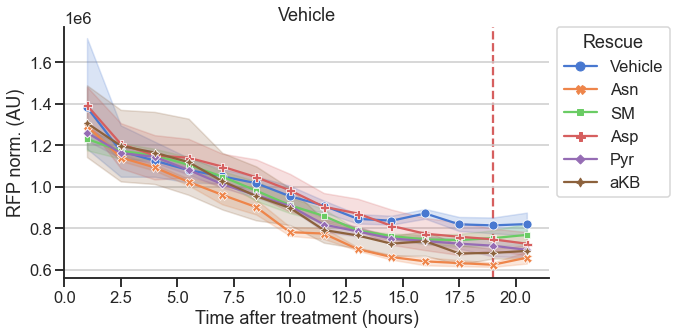

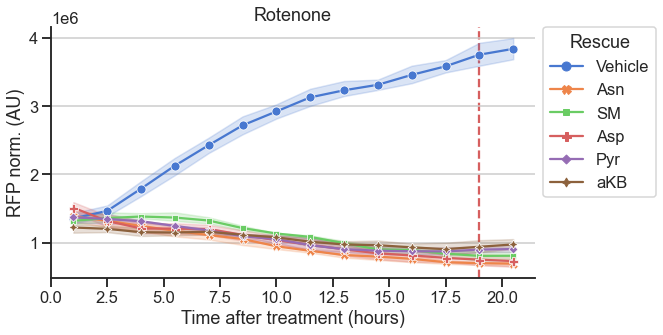

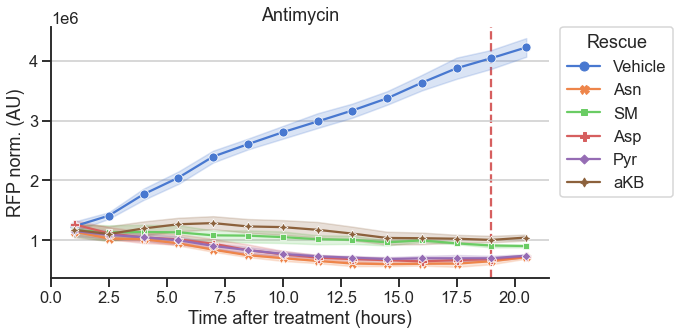

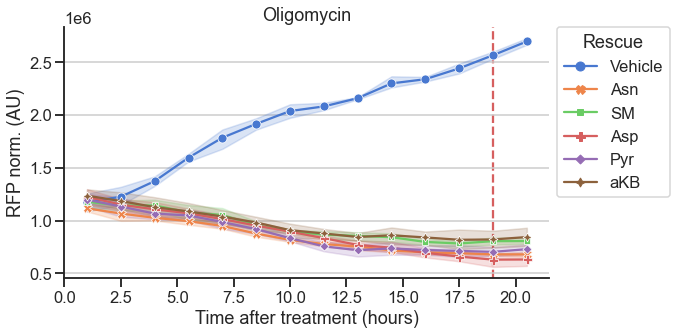

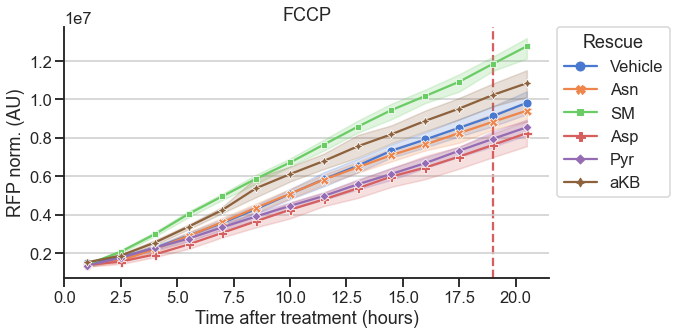

In [85]:
### Plot mito inhibitors for HT1080 ATF4-rep (low) ###


folder = '01-24-22_low'

drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP']
for drug in drug_list:
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

    mask = (data['Folder'] == folder) & (data['Drug'] == drug)

    g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y='RFP', hue='Rescue', ci=90, markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
    ax1.axvline(x=19, color='r', linestyle='--', zorder=0)
    ax1.set_xlim(0, ax1.get_xlim()[1])

    g1.set_ylabel('RFP norm. (AU)')
    g1.set_xlabel('Time after treatment (hours)')
    g1.set_title('{}'.format(drug))
    g1.grid(True, axis='y')
    g1.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0, title='Rescue')

    sns.despine()
    fig.tight_layout()
#fig.savefig('plots/{}-mito-inhib.pdf'.format(folder), bbox_inches='tight')

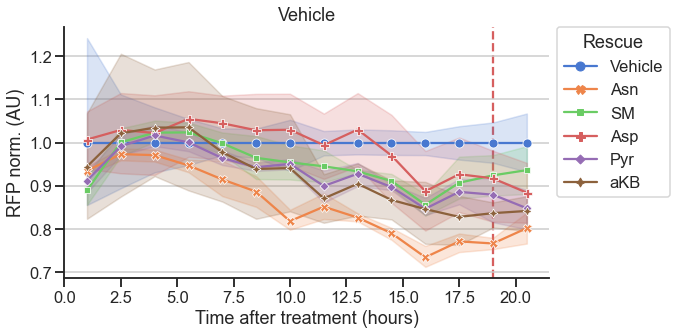

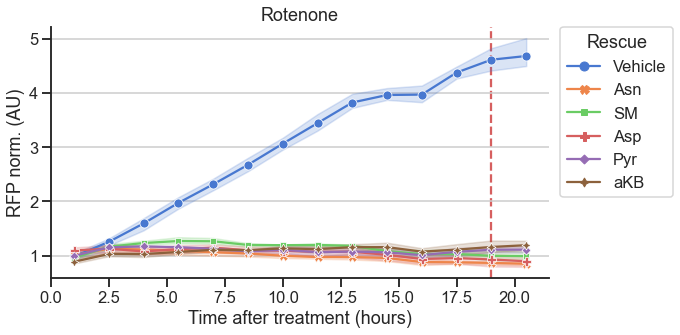

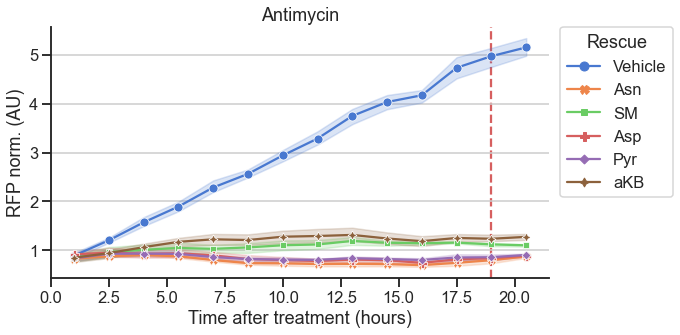

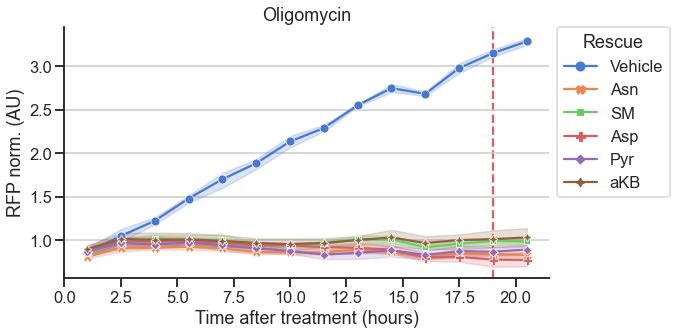

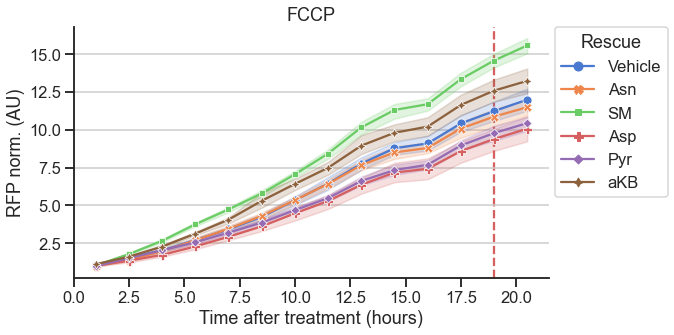

In [169]:
### Plot mito inhibitors for HT1080 ATF4-rep (low) ###


folder = '01-24-22_low'

drug_list = ['Vehicle', 'Rotenone', 'Antimycin', 'Oligomycin', 'FCCP']
for drug in drug_list:
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))

    mask = (data['Folder'] == folder) & (data['Drug'] == drug)

    g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y='RFP_norm', hue='Rescue', ci=90, markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
    ax1.axvline(x=19, color='r', linestyle='--', zorder=0)
    ax1.set_xlim(0, ax1.get_xlim()[1])

    g1.set_ylabel('RFP norm. (AU)')
    g1.set_xlabel('Time after treatment (hours)')
    g1.set_title('{}'.format(drug))
    g1.grid(True, axis='y')
    g1.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0, title='Rescue')

    sns.despine()
    fig.tight_layout()
#fig.savefig('plots/{}-mito-inhib.pdf'.format(folder), bbox_inches='tight')

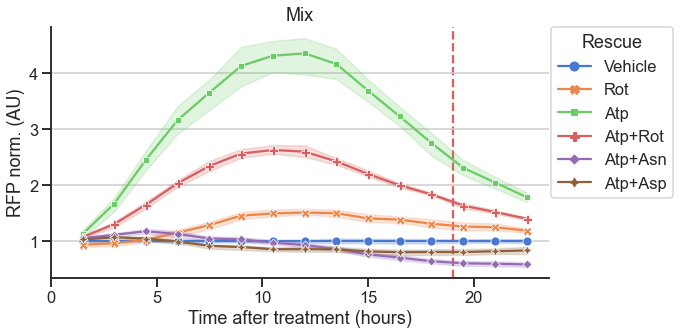

In [179]:
fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
folder = '01-26-22_high'
drug = 'Mix'
mask = (data['Folder'] == folder) & (data['Drug'] == drug)

g1 = sns.lineplot(ax=ax1, data=data[mask], x='Time', y='RFP_norm', hue='Rescue', ci=90, markers=True, style='Rescue', dashes=False, alpha=1, zorder=1)
ax1.axvline(x=19, color='r', linestyle='--', zorder=0)
ax1.set_xlim(0, ax1.get_xlim()[1])

g1.set_ylabel('RFP norm. (AU)')
g1.set_xlabel('Time after treatment (hours)')
g1.set_title('{}'.format(drug))
g1.grid(True, axis='y')
g1.legend(bbox_to_anchor=(1.25, 1), borderaxespad=0, title='Rescue')

sns.despine()
fig.tight_layout()

In [170]:
data

,Folder,Plate,Time,Drug,Rescue,Replicate,RFP,RFP_norm,RFP_vec
0,01-24-22_low,p1,1.0,Vehicle,Vehicle,1,1255969.0,0.908714,1382138.75
1,01-24-22_low,p1,1.0,Vehicle,Vehicle,2,1906907.0,1.379678,1382138.75
2,01-24-22_low,p1,1.0,Vehicle,Vehicle,3,1143466.0,0.827316,1382138.75
3,01-24-22_low,p1,1.0,Vehicle,Vehicle,4,1222213.0,0.884291,1382138.75
4,01-24-22_low,p1,1.0,Vehicle,Asn,1,1314929.0,0.951373,1382138.75
...,...,...,...,...,...,...,...,...,...
4157,01-26-22_high,p6,22.5,Mix,Atp+Asn,4,34063120.0,0.624449,54549110.00
4158,01-26-22_high,p6,22.5,Mix,Atp+Asp,1,50961780.0,0.934237,54549110.00
4159,01-26-22_high,p6,22.5,Mix,Atp+Asp,2,47130550.0,0.864002,54549110.00
4160,01-26-22_high,p6,22.5,Mix,Atp+Asp,3,39274190.0,0.719979,54549110.00
